# Setup

In [1]:
!pip install google-genai gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.3 MB/s eta 0:00:00


In [2]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO
from google.colab import userdata
import requests

client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

# 1. Generación y modificación de imágenes

1. Genera una imagen de un gato realista en la calle

2. Añade un sombrero de algún tipo al gato

3. Busca la url directa de una imagen en internet de algún material con textura curiosa. Carga la imagen.

  ```
  image_url = ...
  style_image = resize_image(Image.open(requests.get(image_url, stream=True).raw))
  ```

4. A partir de esa imagen, genera una imagen de una persona que lleve un vestido de ese material


In [3]:
def resize_image(image):
    width, height = image.size
    new_width = width // 2
    new_height = height // 2
    return image.resize((new_width, new_height))

def text_to_image(prompt):
    response = client.models.generate_content(
        model="gemini-2.0-flash-exp-image-generation",
        contents=prompt,
        config=types.GenerateContentConfig(
          response_modalities=['Text', 'Image']
        )
    )
    image = None
    for part in response.candidates[0].content.parts:
      if part.inline_data is not None:
        image = Image.open(BytesIO((part.inline_data.data)))
        if image is not None:
          image = resize_image(image)
    return image


def image_to_image(image, prompt, apply_resize=True):
    response = client.models.generate_content(
        model="gemini-2.0-flash-exp-image-generation",
        contents=[image, prompt],
        config=types.GenerateContentConfig(
          response_modalities=['Text', 'Image']
        )
    )
    image = None
    for part in response.candidates[0].content.parts:
      if part.inline_data is not None:
        image = Image.open(BytesIO((part.inline_data.data)))
        if image is not None and apply_resize:
          image = resize_image(image)
    return image


def generate_image_from_two_images(text, image1, image2):
    response = client.models.generate_content(
        model="gemini-2.0-flash-exp-image-generation",
        contents=[text, image1, image2],
        config=types.GenerateContentConfig(
          response_modalities=['Text', 'Image']
        )
    )
    image = None
    for part in response.candidates[0].content.parts:
      if part.inline_data is not None:
        image = Image.open(BytesIO((part.inline_data.data)))
        if image is not None:
          image = resize_image(image)
    return image

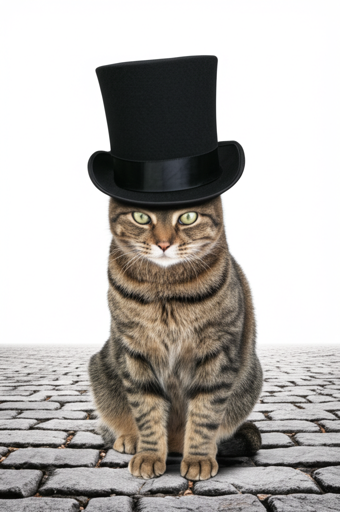

In [4]:
prompt = "A realistic cat sitting on a cobblestone street, wearing a tall black top hat."
result = text_to_image(prompt)
result

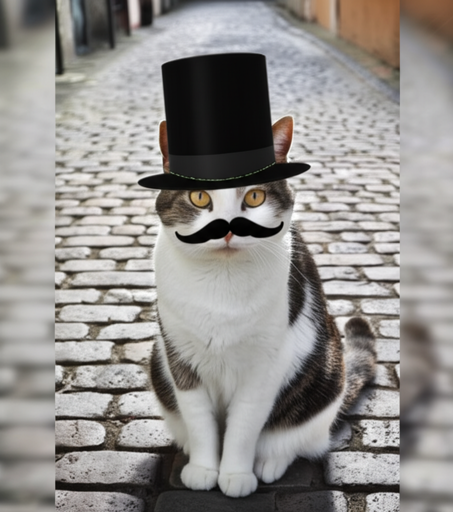

In [10]:
prompt = "A realistic cat sitting on a cobblestone street, wearing a tall black top hat. Add a mustache filter"
result = text_to_image(prompt)
result

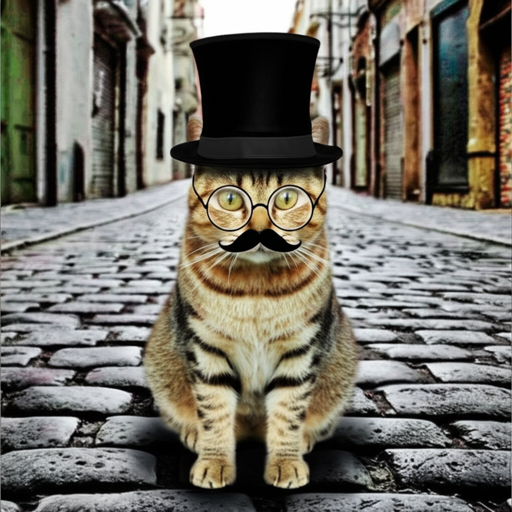

In [11]:
prompt = "A realistic cat sitting on a cobblestone street, wearing a tall black top hat. Add a mustache and eye glasses filter"
result = text_to_image(prompt)
result

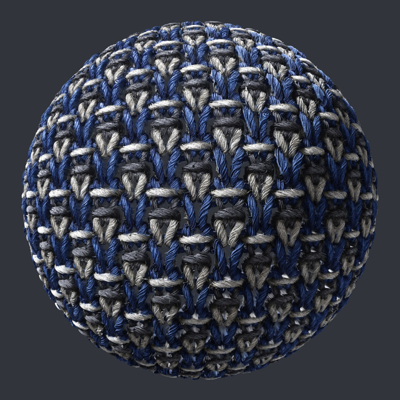

In [5]:
image_url = 'https://www.textures.com/system/gallery/photos/Fabric/114705-Wool/ps147079/147079_header4_small.jpg'
style_image = resize_image(Image.open(requests.get(image_url, stream=True).raw))
style_image

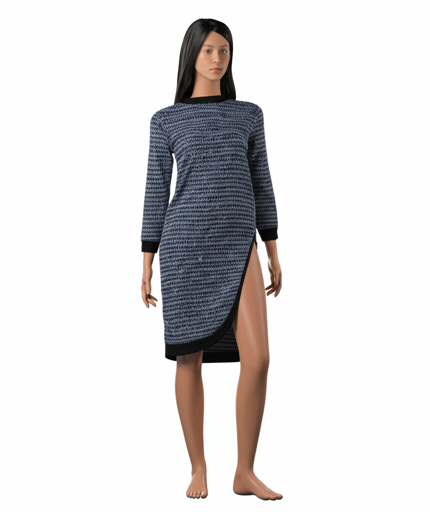

In [6]:
prompt = 'A model with a fashion dress made of this material'
image_to_image(style_image, prompt)

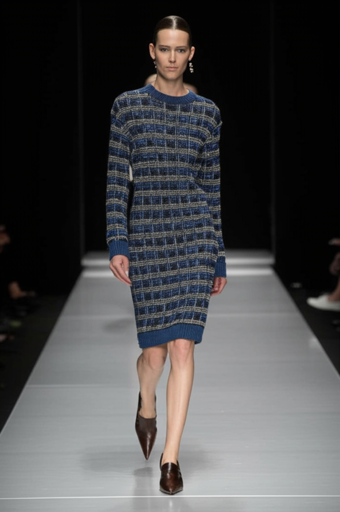

In [9]:
prompt = 'A model with a fashion dress made of this material walking down the runway'
image_to_image(style_image, prompt)

# 2. Photoshop Mágico

Crea una demo donde el usuario pueda subir una imagen y editarla con un prompt.

In [8]:
import gradio as gr

def edit_image_with_prompt(input_image, prompt):
    if input_image is None:
        return None
    result = image_to_image(input_image, prompt,apply_resize=False)

    return result

# Create a Gradio interface
demo = gr.Interface(
    fn=edit_image_with_prompt,
    inputs=[
        gr.Image(type="pil", label="Upload an image to edit"),
        gr.Textbox(label="Enter your edit prompt")
    ],
    outputs=gr.Image(type="pil", label="Edited Image"),
    title="Image Editor with Gemini",
    description="Upload an image and provide a prompt to edit it using Gemini AI.",
    examples=[
        ["https://res.cloudinary.com/petrescue/image/upload/v1598315017/ul4uxmbk6nzyg0662920.jpg", "Add a hat to the cat"]
    ]
)

# Launch the demo
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5849d15a42e8ae51c3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
